# Document Clustering and Topic Modeling

In this project, we use unsupervised learning models to cluster unlabeled documents into different groups, visualize the results and identify their latent topics.

## Contents

<ul>
<li>[Part 1: Load Data](#Part-1:-Load-Data)
<li>[Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
<li>[Part 3: TF-IDF](#Part-3:-TF-IDF)
<li>[Part 4: K-means clustering](#Part-4:-K-means-clustering)
<li>[Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)
</ul>

# Part 1: Load Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lda

Read data from files. In summary, we have 100 titles and 100 synoposes (combined from imdb and wiki).

In [2]:
#import three lists: titles and wikipedia synopses
titles = open('./data/title_list.txt').read().split('\n')
titles = titles[:100] #ensures that only the first 100 are read in

#The wiki synopses and imdb synopses of each movie is seperated by the keywords "BREAKS HERE". 
#Each synoposes may consist of multiple paragraphs.
synopses_wiki = open('./data/synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('./data/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

#Combine imdb and wiki to get full synoposes for the top 100 movies. 
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

#Because these synopses have already been ordered in popularity order, 
#we just need to generate a list of ordered numbers for future usage.
ranks = range(len(titles))

# Part 2: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [3]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

print("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print(stopwords[:10])

We use 153 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']


In [4]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
#     tokens=[]
#     for sent in nltk.sent_tokenize(text):
#         for word in nltk.word_tokenize(sent):
#             if word not in stopwords:
#                 tokens.append(word);   
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [5]:
tokenization_and_stemming("she looked at her father's arm.")

['look', 'father', "'s", 'arm']

Use our defined functions to analyze (i.e. tokenize, stem) our synoposes.

In [6]:
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    
    tokenized_results = tokenization(i)
    docs_tokenized.extend(tokenized_results)

Create a mapping from stemmed words to original tokenized words for result interpretation.

In [10]:
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
print(vocab_frame_dict['angel'])
print(len(docs_stemmed))

angeles
184667


# Part 3: TF-IDF

In [11]:
#define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(synopses) #fit the vectorizer to synopses

print("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " synoposes and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 100 synoposes and 538 terms.


In [12]:
tfidf_model.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 200000,
 'min_df': 0.2,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming>,
 'use_idf': True,
 'vocabulary': None}

Save the terms identified by TF-IDF.

In [13]:
tf_selected_words = tfidf_model.get_feature_names()
print(tf_selected_words)

["'d", 'abandon', 'abl', 'accept', 'accid', 'accompani', 'accus', 'act', 'action', 'actual', 'admit', 'afterward', 'ago', 'agre', 'air', 'aliv', 'allow', 'alon', 'alreadi', 'alway', 'american', 'angri', 'angrili', 'announc', 'anoth', 'answer', 'anyon', 'anyth', 'apart', 'appar', 'appear', 'approach', 'area', 'argu', 'arm', 'armi', 'arrang', 'arrest', 'arriv', 'ask', 'assign', 'assist', 'assum', 'attack', 'attempt', 'attend', 'attent', 'attract', 'audienc', 'avoid', 'away', 'bad', 'bar', 'bare', 'battl', 'beat', 'becom', 'bed', 'beg', 'believ', 'best', 'better', 'big', 'black', 'blow', 'board', 'bodi', 'book', 'boss', 'boy', 'break', 'brief', 'bring', 'broken', 'brother', 'build', 'burn', 'busi', 'buy', 'ca', 'camp', 'captain', 'captur', 'car', 'care', 'career', 'carri', 'case', 'catch', 'caus', 'chanc', 'chang', 'charg', 'chase', 'child', 'children', 'citi', 'claim', 'clear', 'climb', 'close', 'cloth', 'club', 'cold', 'collaps', 'come', 'command', 'commit', 'compani', 'complet', 'conce

# (Optional) Calculate Document Similarity

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)
print(cos_matrix)
print(len(cos_matrix[0]))

[[ 1.          0.1996283   0.23342595 ...,  0.3581728   0.3277855
   0.17714484]
 [ 0.1996283   1.          0.26626879 ...,  0.26910321  0.22856581
   0.10870124]
 [ 0.23342595  0.26626879  1.         ...,  0.27738654  0.24669308
   0.12805055]
 ..., 
 [ 0.3581728   0.26910321  0.27738654 ...,  1.          0.55040973
   0.08151334]
 [ 0.3277855   0.22856581  0.24669308 ...,  0.55040973  1.          0.13005234]
 [ 0.17714484  0.10870124  0.12805055 ...,  0.08151334  0.13005234  1.        ]]
100


# Part 4: K-means clustering

In [15]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

## 4.1. Analyze K-means Result

In [16]:
# create DataFrame films from all of the input files.
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters}
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster'])

In [17]:
frame.head(10)

rank                            title  cluster
3     0                    The Godfather        3
2     1         The Shawshank Redemption        2
1     2                 Schindler's List        1
2     3                      Raging Bull        2
3     4                       Casablanca        3
2     5  One Flew Over the Cuckoo's Nest        2
0     6               Gone with the Wind        0
2     7                     Citizen Kane        2
0     8                 The Wizard of Oz        0
0     9                          Titanic        0

In [18]:
print("Number of films included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of films included in each cluster:


cluster
3       26
2       25
0       24
1       19
4        6

In [19]:
grouped = frame['rank'].groupby(frame['cluster'])
print("Average rank (1 to 100) per cluster:")
grouped.mean().to_frame()

Average rank (1 to 100) per cluster:


rank
cluster           
0        49.500000
1        43.473684
2        50.120000
3        52.538462
4        52.833333

In [20]:
print("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
print(order_centroids)

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print("Cluster " + str(i) + " words:") ,
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print(vocab_frame_dict[tf_selected_words[ind]] + ","),
    #Here ix means index, which is the clusterID of each item.
    #Without tolist, the values result from dataframe is <type 'numpy.ndarray'>
    cluster_movies = frame.ix[i]['title'].values.tolist()
    print("Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): ")
    print(", ".join(cluster_movies))

<Document clustering result by K-means>
[[194 241 318 ..., 365  29  64]
 [452  35 106 ...,  45  68 536]
 [320 201 367 ..., 496 370 261]
 [271 359  83 ..., 205 474 367]
 [213 302 192 ..., 389 232 131]]
Cluster 0 words:
father,
home,
mother,
new,
love,
house,
Cluster 0 titles (24 movies): 
Gone with the Wind, The Wizard of Oz, Titanic, Forrest Gump, E.T. the Extra-Terrestrial, 2001: A Space Odyssey, Amadeus, The Best Years of Our Lives, My Fair Lady, Ben-Hur, Doctor Zhivago, Braveheart, The Good, the Bad and the Ugly, The Exorcist, City Lights, It Happened One Night, Midnight Cowboy, Mr. Smith Goes to Washington, Rain Man, Annie Hall, Out of Africa, Terms of Endearment, Network, Yankee Doodle Dandy
Cluster 1 words:
soldiers,
army,
commanded,
killing,
war,
general,
Cluster 1 titles (19 movies): 
Schindler's List, Lawrence of Arabia, Star Wars, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Retu

## 4.2. Plot K-means Result

In [46]:
pca = decomposition.PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
#set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

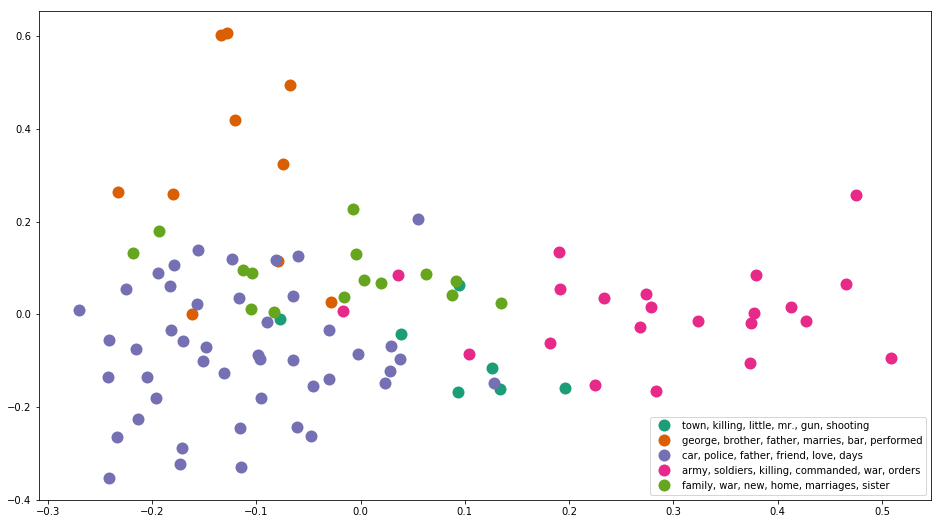

In [52]:
%matplotlib inline 

#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
groups = df.groupby(clusters)

# set up plot
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')

ax.legend(numpoints=1,loc=4)  #show legend with only 1 point, position is right bottom.

plt.show() #show the plot

In [41]:
plt.close()

# Appendix: K-means

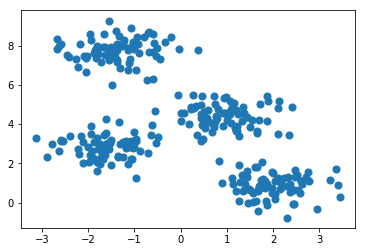

In [58]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

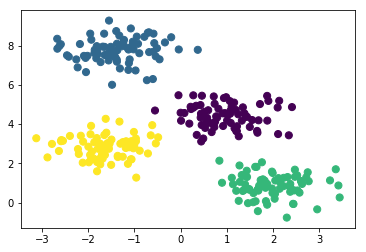

In [59]:
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50);